In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# %matplotlib inline

from time import time
from operator import itemgetter
from datetime import datetime
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


# Functions

In [67]:
def finish():
    os.system("paplay /usr/share/sounds/gnome/default/alerts/drip.ogg")
    os.system("paplay /usr/share/sounds/gnome/default/alerts/glass.ogg")

In [170]:
bestLogloss = 0.503616393572
def evaluate(model, X, y, string, more = ""):
    title = string + " score: " + more
    score = model.score(X, y)
    scoreLogloss = log_loss(y, model.predict_proba(X))
    
    currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    if model.get_params().has_key('forest'):
        modelExplaination = model.get_params()['forest'].__class__.__name__ + str(model.get_params()['forest'].get_params())
    else:
        modelExplaination = model.__class__.__name__  + str(model.get_params())
    
    logline = str(score) + ";" + str(scoreLogloss) + ";" + currentDate + ";" + str(modelExplaination) + ";" + more
    
    with open("evaluate"+string+".log", "a") as myfile:
        myfile.write(logline+"\n")
    
    print title
    print score
    print str(scoreLogloss)  + " compare to best score: " + str(scoreLogloss-bestLogloss) 

# Load

In [2]:
kaggleTrain = pd.read_csv("kaggle/train.csv", header = 0)
kaggleTest = pd.read_csv("kaggle/test.csv", header = 0)

In [3]:
print "Kaggle Train count: " + str(len(kaggleTrain))
print "Kaggle Test count:  " + str(len(kaggleTest))

Kaggle Train count: 114321
Kaggle Test count:  114393


## Columns listing

In [73]:
#print train.schema.fields
columnsDict = {}
for col in kaggleTrain.columns:
    typeKey = str(kaggleTrain[col].dtype)
    colName = col
    
    if colName == 'ID':
        print "We have the ID columns, type: " + typeKey
        continue
    if colName == 'target':
        print "We have the target columns, type: " + typeKey
        continue
    
    if typeKey not in columnsDict:
        columnsDict[typeKey] = [colName]
    else:
        columnsDict[typeKey].append(colName)

print ""
for ct, cl in columnsDict.iteritems():
    print ct + " " + str(len(cl))

We have the ID columns, type: int64
We have the target columns, type: int64

object 19
int64 4
float64 108


# Split

In [74]:
train, test = train_test_split(kaggleTrain, test_size = 0.2)

In [172]:
train[columnsDict['object']].apply(pd.Series.nunique)

v3          3
v22     16641
v24         5
v30         7
v31         3
v47        10
v52        12
v56       118
v66         3
v71         8
v74         3
v75         4
v79        17
v91         7
v107        7
v110        3
v112       22
v113       36
v125       90
dtype: int64

In [207]:
uniqueValues = train['v30'].unique()
dictValues = dict()
for v in uniqueValues:
    if v is nan:
        print "lol"
        continue
    if not v in dictValues:
        dictValues[v] = len(dictValues)
dictValues[nan] = -1
        
dictValues
        

lol


{nan: -1, 'A': 3, 'B': 6, 'C': 1, 'D': 2, 'E': 5, 'F': 4, 'G': 0}

# Prepare X and y

In [75]:
print len(columnsDict['float64']) +  len(columnsDict['int64'])

112


In [244]:
catEncoders = dict()
# Create the mapping from categorie to int
for col in columnsDict['object']:
    # Create dictionnary
    uniqueValues = kaggleTrain[col].unique()
    dictValues = dict()
    for v in uniqueValues:
        if v is nan:
            continue
        if not v in dictValues:
            dictValues[v] = len(dictValues)
    dictValues[nan] = -1
    
    # If value is in the training but not in the testing, then map to missing -1
    uniqueValuesTesting = kaggleTest[col].unique()
    for v in set(uniqueValues) - set(uniqueValuesTesting):
        dictValues[v] = -1

    catEncoders[col] = dictValues
    

def prepareX(df, isTrainning):
    colsToAdd = columnsDict['float64'] + columnsDict['int64']
    
    dfX = df[colsToAdd]
    dfX = dfX.fillna(-1) # -1 is a good missing value encoder because everything is >= 0
    
    for col in colsToAdd:
        dfX[col+"_m"] = df[col]
        
    # Add categorical features, and teplace categories with int
    dfX[columnsDict['object']] = df[columnsDict['object']]
    dfX = dfX.replace(catEncoders)
        
    
    return dfX

In [216]:
def prepareY(df):   
    return df[["target"]].values.ravel()

In [217]:
X_train = prepareX(train, True)
y_train = prepareY(train)

In [245]:
X_test = prepareX(test, False)
y_test = prepareY(test)

In [221]:
colsMissingValues = X_train.isnull().sum()
print len(train.columns)
print len(colsMissingValues)

133
243


# Model

In [247]:
#.setNumTrees(150).setMaxDepth(6)
clf = RandomForestClassifier(n_estimators=150,
                             n_jobs=4,
                             max_depth=10,
                             criterion='gini') #  max_depth=7

In [232]:
clf = ExtraTreesClassifier(n_estimators=850, max_features=60, criterion='entropy', min_samples_split=4,
                            max_depth=40, min_samples_leaf=2, n_jobs=-1)     

In [233]:
#clf.fit(X_train, y_train)

# Pipeline

In [248]:
imputer = Imputer(missing_values="NaN",
                  strategy="mean",
                  axis=0)

In [249]:
estimator = Pipeline([("imputer", imputer),
                      ("forest", clf)
                     ])

In [250]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

## Scoring

In [251]:
evaluate(estimator, X_train, y_train, "Training", "estimator")

Training score: estimator
0.784224107768
0.456614737274 compare to best score: -0.0470016562978


In [252]:
evaluate(estimator, X_test, y_test, "Testing", "estimator")

Testing score: estimator
0.761425759895
0.499517974634 compare to best score: -0.00409841893789


## Features Analysis

In [239]:
def feature_analysis(model, X):
    importancePd = pd.DataFrame(model.feature_importances_, columns=["importance"])
    importancePd["feature"] = X.columns
    
    importancePd = importancePd.sort(['importance'], ascending=[0])
    importancePd = importancePd.set_index(['feature'])
    
    print importancePd.head(n=10)

    plt.figure();
    pylab.rcParams['figure.figsize'] = (30, 3)
    importancePd[:50].plot(kind='bar');
    importancePd[50:200].plot(kind='bar');
    plt.axhline(0, color='k')
    
    # Feature selection
    
    

         importance
feature            
v50_m      0.048975
v50        0.047768
v66        0.027495
v52        0.016598
v112       0.015025
v10_m      0.015022
v125       0.014745
v24        0.014698
v10        0.014428
v56        0.014330


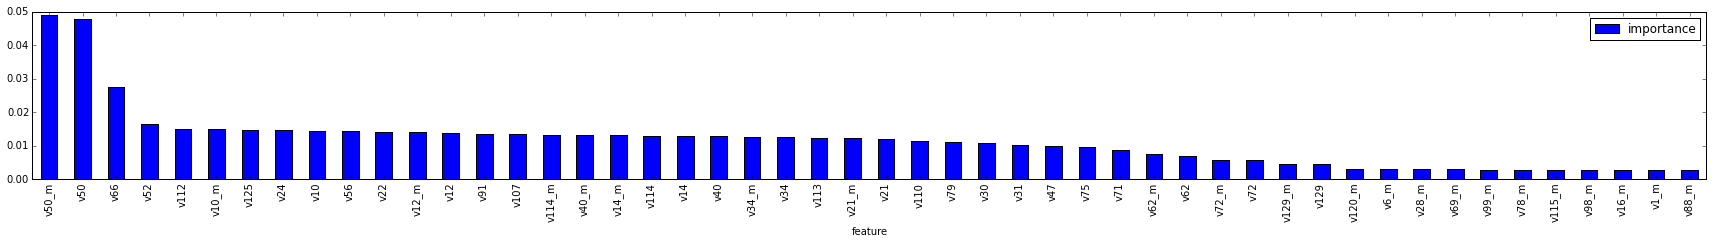

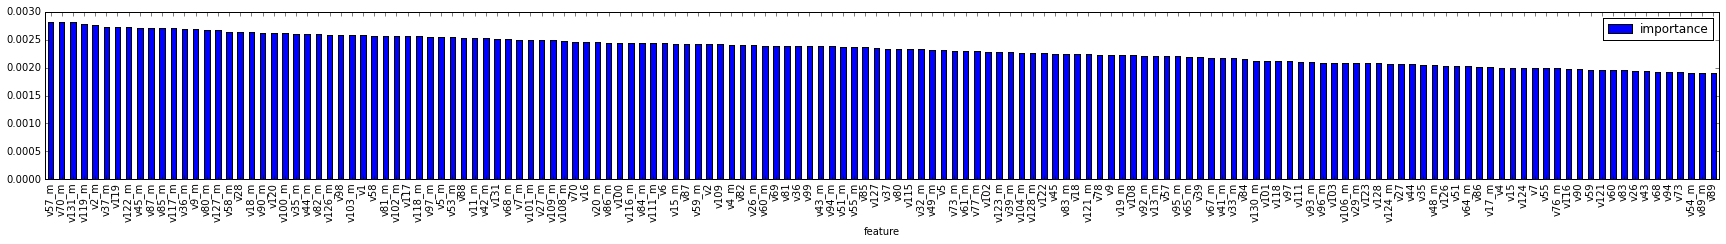

In [242]:
feature_analysis(clf, X_train)

# Grid search

In [127]:
# Utility function to report best scores
def report(grid_scores, n_top=3, save=False):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if save:
            currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            logline = str("{0}".format(i + 1)) + ";" + "{0:.5f};{1:.5f}".format(score.mean_validation_score,np.std(score.cv_validation_scores)) + ";" + currentDate + ";" + "{0}".format(score.parameters)
            with open("gridSearch.log", "a") as myfile:
                myfile.write(logline+"\n")

In [114]:
sqrt(len(X_train.columns))

14.966629547095765

In [253]:
# specify parameters and distributions to sample from
modelName = "forest__"
param_dist = {modelName+"max_depth": [None],          # Default -> None | If Nonen then nodes are expanded until min_samples_split (Ignored if max_leaf_nodes is not None.)
              modelName+"max_features": sp_randint(15, 21),#sp_randint(14, 24),      # Default -> sqrt(n_features) ~14
              modelName+"min_samples_split": sp_randint(1, 5), # Default -> 2 (useless if mex_depth not None)
              modelName+"min_samples_leaf": sp_randint(1, 15),  # Default -> 1
              modelName+"bootstrap": [False]              # Default -> True
              #modelName+"criterion": ["gini", "entropy"] # gini
             }

# run randomized search
n_iter_search = 20
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="log_loss")

In [ ]:
start = time()
grid_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.grid_scores_)
finish()

In [ ]:
report(grid_search.grid_scores_, 20, True)

In [ ]:
evaluate(grid_search.best_estimator_, X_test, y_test, "Testing", "GridSearchBest")

# Save

In [229]:
modelToSave = estimator
#modelToSave = grid_search.best_estimator_

In [230]:
X_kaggleTest = prepareX(kaggleTest, False)

In [231]:
predic = modelToSave.predict_proba(X_kaggleTest)[:,1] # extract 2nd column for X=1

ValueError: could not convert string to float: K

In [ ]:
predicPd = pd.DataFrame(predic)
predicPd = predicPd.rename(columns={0: 'PredictedProb'})
predicPd['ID'] = kaggleTest[['ID']]
predicPd = predicPd[['ID', 'PredictedProb']]

In [ ]:
predicPd.to_csv("results/pythonpure/results.csv", index = False)